In [1]:
#!pip install PyWavelets mne  pandas numpy matplotlib

In [2]:
!pip install torch

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pywt
from torch.utils.data import DataLoader, Dataset
import torch
import pickle
import os

In [4]:
def file_to_DataDrame(path):
    """
    This function takes in a file path and returns a dataframe with the data and the target values
    format:
        Fc5	        Fc3	        Fc1	        ...	Oz	        O2	        Iz	        target
    0	-0.000046	-0.000041	-0.000032	...	0.000040	0.000108	0.000055	0
    1	-0.000054	-0.000048	-0.000034	...	0.000064	0.000114	0.000074	0
    ...
    """

    reader = mne.io.read_raw_edf(path, preload=True)
    annotations = reader.annotations  # get the values of the annotations
    codes = annotations.description  # get the codes from the annotations

    df = pd.DataFrame(
        reader.get_data().T,
        columns=[channel.replace(".", "") for channel in reader.ch_names],
    )  # transpose the data to get the right shape
    df = df[~(df == 0).all(axis=1)]  # remove rows with all zeros
    timeArray = np.array(
        [round(x, 10) for x in np.arange(0, len(df) / 160, 0.00625)]
    )  # create an array of time values

    codeArray = []
    counter = 0
    for timeVal in timeArray:
        if (
            timeVal in annotations.onset
        ):  # if the time value is in the onset array, add the corresponding code to the codeArray
            counter += 1
        code_of_target = int(
            codes[counter - 1].replace("T", "")
        )  # convert T0 to 0, T1 to 1, etc
        codeArray.append(code_of_target)

    df["target"] = np.array(codeArray).T
    return df


def save_to_pickle(data, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(data, f)


def load_from_pickle(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

In [5]:
def read_all_file_df(num_exp=[3, 4], num_people=2):
    """condct all files in one dataframe"""
    all_df = pd.DataFrame()
    for subject in range(1, num_people):
        for file in num_exp:
            fileName = f"files/S{subject:03d}/S{subject:03d}R{file:02d}.edf"
            df = file_to_DataDrame(fileName)
            all_df = pd.concat([all_df, df], axis=0)
    return all_df

In [6]:
df = read_all_file_df()

Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [7]:
len(df)

39840

In [8]:
def chanks_to_CWTchanks(chunks):
    for i, signals in enumerate(chunks):

        time = np.linspace(0, len(signals) / 160, len(signals))
        widths = np.geomspace(1, 200, num=100)  # range of scales
        sampling_period = np.diff(time).mean()  # 0.006251562890722681

        cwtmatr, freqs = pywt.cwt(
            signals, widths, "cgau4", sampling_period=sampling_period
        )
        # cwtmatr= np.abs(cwtmatr[:-1,:-1])
        cwtmatr = np.abs(cwtmatr)
        # cwtmatr= torch.tensor(cwtmatr)
        temp_file = f"cwt_data/cwt_{i}.pkl"
        save_to_pickle(cwtmatr, temp_file)
        del cwtmatr

In [9]:
num_of_rows = 1000
chunks = [df[i : i + num_of_rows] for i in range(0, df.shape[0], num_of_rows)]
chanks_to_CWTchanks(chunks)

In [10]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [11]:
dataset = EEGDataset(df.iloc[:, :-1].values, df.iloc[:, -1].values)

In [12]:
dataset.__getitem__(0)

(array([-5.70e-05, -1.30e-05, -1.50e-05, -1.20e-05, -1.30e-05, -8.00e-06,
        -4.00e-05, -5.40e-05, -1.20e-05, -1.40e-05, -2.90e-05, -1.50e-05,
        -1.50e-05, -2.50e-05, -1.00e-05, -1.40e-05, -2.10e-05, -2.50e-05,
        -2.30e-05, -3.40e-05, -2.40e-05, -1.10e-04, -8.90e-05, -1.31e-04,
        -5.40e-05, -5.50e-05, -5.10e-05, -7.00e-05, -1.06e-04, -2.00e-05,
        -3.30e-05, -2.80e-05, -3.10e-05, -2.90e-05, -3.10e-05, -2.70e-05,
        -5.70e-05, -8.80e-05, -1.80e-05, -3.80e-05,  2.00e-06, -1.10e-05,
         7.00e-06, -4.60e-05, -2.00e-06, -4.40e-05, -7.00e-06, -1.60e-05,
        -4.30e-05, -4.20e-05, -4.40e-05, -4.50e-05, -4.40e-05, -5.20e-05,
        -4.80e-05, -3.80e-05, -4.20e-05, -6.80e-05, -7.60e-05, -1.03e-04,
        -5.10e-05, -5.60e-05, -1.24e-04, -2.80e-05]),
 0)

In [13]:
signal = dataset.data[:, 1]
signal = signal[:1000]

In [14]:
print(signal.shape)
print(signal.dtype)
print(type(signal))

(1000,)
float64
<class 'numpy.ndarray'>


In [15]:
# normalization signal
signal = (signal - signal.mean()) / signal.std()

In [16]:
time = np.linspace(0, len(signal) / 160, len(signal))
widths = np.geomspace(1, 200, num=100)  # range of scales
sampling_period = np.diff(time).mean()  # 0.006251562890722681
print(signal.shape)
cwtmatr, freqs = pywt.cwt(signal, widths, "cgau4", sampling_period=sampling_period)
# cwtmatr= np.abs(cwtmatr[:-1,:-1])
cwtmatr = np.abs(cwtmatr)
# cwtmatr= torch.tensor(cwtmatr)

(1000,)


In [17]:
signal.shape

(1000,)

(100, 1000)


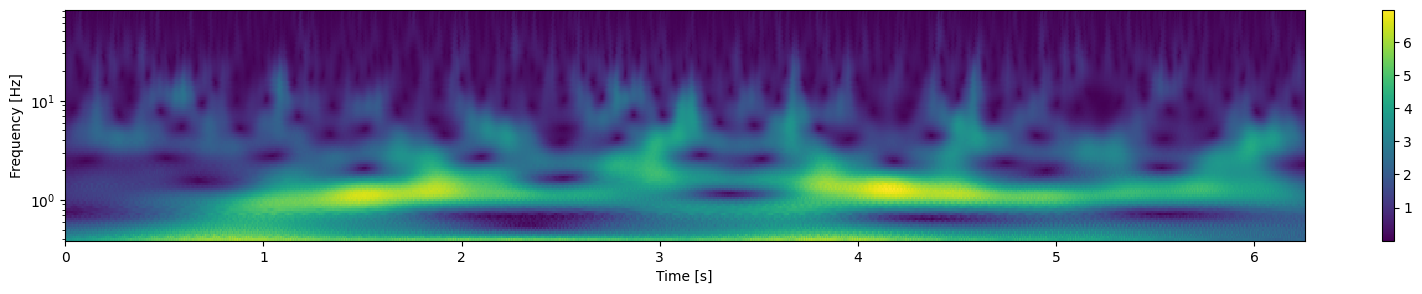

In [18]:
plt.figure(figsize=(20, 3))
print(cwtmatr.shape)
plt.pcolormesh(time, freqs, cwtmatr)
maxval = np.max(freqs)
plt.yscale("log")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.colorbar()
plt.show()

In [19]:
signals = dataset.data[:1000]

signals.shape

(1000, 64)

In [20]:
signals = (signals - signals.mean()) / signals.std()
time = np.linspace(0, len(signals) / 160, len(signals))
widths = np.geomspace(1, 200, num=100)  # range of scales
sampling_period = np.diff(time).mean()  # 0.006251562890722681
print(signal.shape)
cwtmatr, freqs = pywt.cwt(signals, widths, "cgau4", sampling_period=sampling_period)
# cwtmatr= np.abs(cwtmatr[:-1,:-1])
cwtmatr = np.abs(cwtmatr)
# cwtmatr= torch.tensor(cwtmatr)

(1000,)


In [21]:
cwtmatr[:,:, 0].shape

(100, 1000)

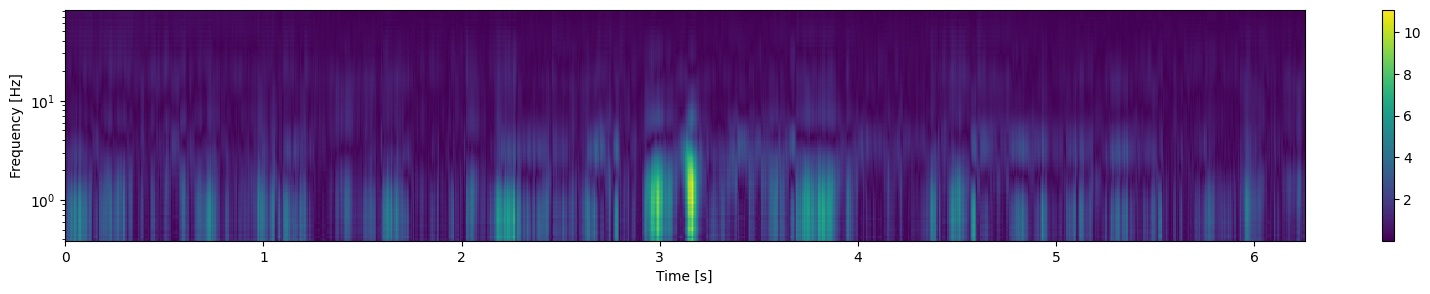

In [23]:
plt.figure(figsize=(20, 3))
plt.pcolormesh(time, freqs, cwtmatr[:, :, 1])
maxval = np.max(freqs)
plt.yscale("log")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.colorbar()
plt.show()